# Detect Credit Card Fraud
Machine learning will be used to detect fradulent credit card transaction. Data is from transactions made by credit cards in September 2013 by european cardholders which can be found here: https://www.kaggle.com/mlg-ulb/creditcardfraud. 

The final predictive models using AUC is:
* KNN 0.9844
* Linear Regression 0.9844
* Gradient boosting regression 0.93
* AUC for decision tree is: 0.9338
* Logistic regression 0.905

The train dataset has 5 rows × 31 columns with the first five rows can be seen below in the next section.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.datasets import make_classification
from sklearn import ensemble
from sklearn import metrics

#creditCard=r'/kaggle/input/creditcardfraud/creditcard.csv'
creditCard=r'C:\Users\sschm\Desktop\Kaggle\creditcard.csv'
data=pd.read_csv(creditCard)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Find missing data
There is no missing data.

In [2]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = data.select_dtypes(include=numerics)

print("Missing data by column:")
findNA=df.isnull().sum().sort_values(ascending=False)/len(data)
print(findNA.head()) #There are no missing values

Missing data by column:
Time      0.0
V16       0.0
Amount    0.0
V28       0.0
V27       0.0
dtype: float64


### Unbalanced Dataset
Since the amount of fraudelent transactions is 0.0017, the dataset is considered highly unbalanced. This means metrics used should be the following: recall, precision, and AOC. R-squared should not be used for an unbalanced dataset.

In [3]:
temp = df["Class"].value_counts()
fraud = temp[1]
notFraud= temp[0]
fraudNumbers=round((fraud/notFraud),4)
print(fraudNumbers, "percent of transactions are fraudelent.")

0.0017 percent of transactions are fraudelent.


### Correlations using heatmap
No multicollinearity was detected. The highest correlation between features was V7 and Amount which had a 0.39730 correlation.

AxesSubplot(0.125,0.125;0.62x0.755)
Highly correlated variables above:  0.2


,Correlation
V7 and Amount,0.397300
V20 and Amount,0.339400
V6 and Amount,0.216000
V3 and Amount,-0.210900
V10 and Class,-0.216900
V1 and Amount,-0.227700
Time and V25,-0.233100
Time and V11,-0.247700
V12 and Class,-0.260600
V14 and Class,-0.302500


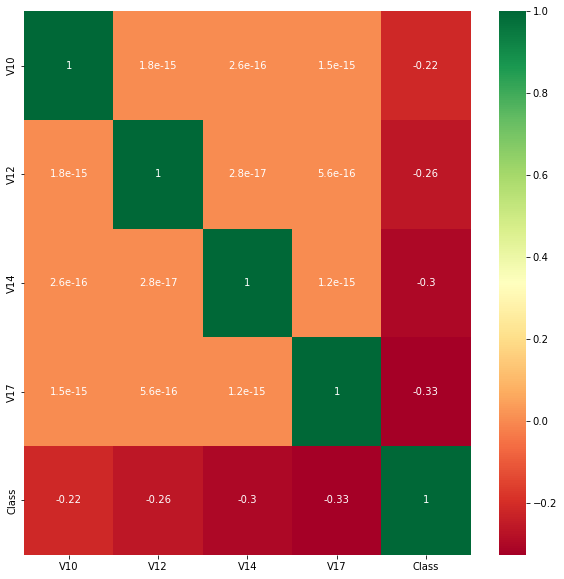

In [4]:
def printHeat():
    corr = df.corr()
    #print(corr)
    highly_corr_features = corr.index[abs(corr["Class"])>0.2]
    plt.figure(figsize=(10,10))
    heat = sns.heatmap(data[highly_corr_features].corr(),annot=True,cmap="RdYlGn")
    top10=corr["Class"].sort_values(ascending=False).head(10).round(4)
    print(heat)
    #print(top10) # top ten correlations

#print correlation between features
def printHighCorr(df, features, threshold=0.2):
    print("Highly correlated variables above: ", threshold)
    corr_df = df[features].corr() # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
    correlation_df={}
    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            correlation_df[corr_df.index[i] +" and "+ corr_df.columns[j]]= v
        correlation_df=pd.DataFrame(correlation_df,index=['Correlation']).round(4)
    return  correlation_df.T.sort_values(by='Correlation',ascending=False)

#Turn functions on or off below:
printHeat() 
printHighCorr(data,data.columns).style.set_properties(**{'background-color': 'black','color': 'white'})

### Split Data
Use 70% of the train data to predict the accuracy of the remaining 30% of the test data.

In [5]:
X=df.drop('Class', axis=1)
y=df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

 ### Gradient Boost with Feature Importance

Gradient boosting regression r2:  0.0281
The mean squared error (MSE) on test set: 0.0015
Gradient boosting regression AUC:  0.93


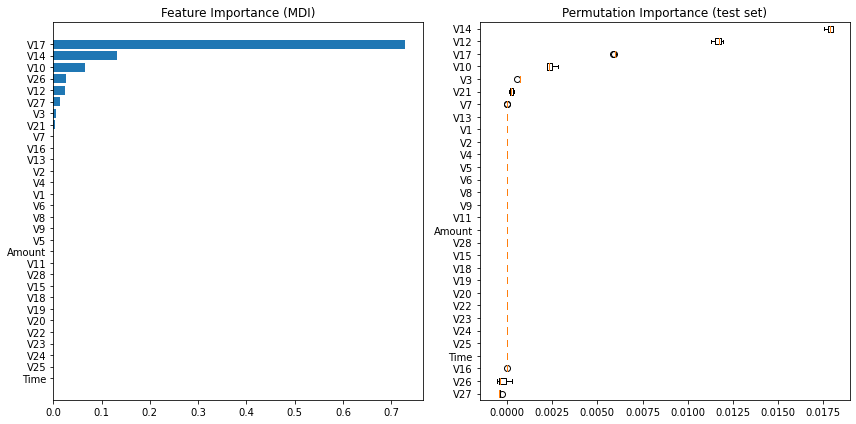

In [6]:
#GRADIENT BOOST REGRESSION:
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from sklearn import ensemble

params = {
 "n_estimators": 2, "max_depth": 4, "min_samples_split": 5, "learning_rate": 0.01,
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
gbr_r2 = r2_score(y_test, y_pred).round(4) 
print("Gradient boosting regression r2: ", gbr_r2) 

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

#calculate AUC of model
auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("Gradient boosting regression AUC: ", auc )

#FEATURE IMPORTANCE:
cols=X.columns
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(cols)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Linear Regression
AUC for linear regression is:  0.9844 <br>
Linear regression r2 score:  0.5375 <br>
Linear Accuracy:  0.5375 <br>
0.4573  linear regression cross validate mean <br>

AUC for linear regression is:  0.9844
Linear regression r2 score:  0.5375
Linear Accuracy:  0.5375
0.4573  linear regression cross validate mean


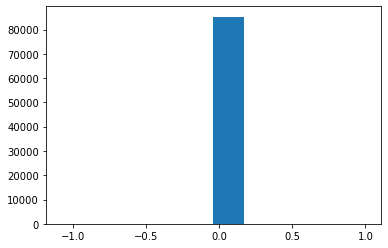

In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#Fit and predict:
lrModel = LinearRegression()
lrModel.fit(X_train, y_train)
lrPredict = lrModel.predict(X_test)

# plt.scatter(y_test, predictions)
plt.hist(y_test - lrPredict)

#Linear Metrics:
auc = round( metrics.roc_auc_score(y_test, lrPredict), 4 ) 
r2 = r2_score(y_test, lrPredict).round(4) 
print("AUC for linear regression is: ", auc)
print("Linear regression r2 score: ", r2)

#CROSS VALIDATE TEST RESULTS:
lr_score = lrModel.score(X_test, y_test).round(4)  # train test 
print("Linear Accuracy: ", lr_score)
lr_cv = cross_validate(lrModel, X, y, cv = 5, scoring= 'r2')
lr_cvMean=lr_cv['test_score'].mean().round(4)
print(lr_cvMean, " linear regression cross validate mean")

def linearReports():
    print(model.coef_)    
    print(model.intercept_)
    print(classification_report(y_test_data, lrPredict))
    print(confusion_matrix(y_test_data, lrPredict))
    metrics.mean_absolute_error(y_test, lrPredict)
    np.sqrt(metrics.mean_squared_error(y_test, lrPredict))

## Logistic Regression
AUC for logistic regression is:  0.905

In [8]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(solver='liblinear') #solver param gets rid of encoder error

#Train the model and create predictions
logReg.fit(X_train, y_train)
logPredict = logReg.predict_proba(X_test)[::,1]

#calculate AUC of model
auc = round( metrics.roc_auc_score(y_test, logPredict), 4 ) 
print("AUC for logistic regression is: ", auc)

AUC for logistic regression is:  0.905


## Decision Tree
The best_max_tree is automated into the decision tree. The results were the following:
* Decision Tree r-squared is: 0.8459 <br>
* AUC for decision tree is:  0.9338

In [9]:
from sklearn.tree import DecisionTreeRegressor

#FIND best_tree_size LEAF NODES:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=42)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
maeDic={} #dictionary  key=leaf  mae=value
for leaf in candidate_max_leaf_nodes:
    mae=get_mae(leaf, X_train, X_test, y_train, y_test)
    maeDic[leaf]=mae

best_tree_size = sorted(maeDic, key=lambda x : maeDic[x])[0]

#MAKE PREDICTION:
tree = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state=42)
tree.fit(X, y)
y_pred = tree.predict(X_test)

#AUC and r2 metric
tree_r2 = r2_score(y_test, y_pred).round(4)
print("Decision Tree r-squared is:", tree_r2)
tree_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("AUC for decision tree is: ", tree_auc)

def printReports(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Decision Tree r-squared is: 0.8459
AUC for decision tree is:  0.9338


## K-Nearest Neigbors
KNN model AUC is:  0.9844.  K equal to 1 seems to be the best fit for n_neighbors when running the function knnError.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def knnErorr():
    print("Selecting an optimal K value:")
    error_rates = []
    for i in range(1, 6, 2): #Must be an odd number to break a tie
        new_model = KNeighborsClassifier(n_neighbors = i)
        new_model.fit(X_train, y_train)
        new_predictions = new_model.predict(X_test)
        error_rates.append(np.mean(new_predictions != y_test))

    plt.figure(figsize=(16,12))
    plt.plot(error_rates)

#Train the model and make predictions:
knn = KNeighborsClassifier(n_neighbors =1) 
knn.fit(X_train, y_train)
knnPredict= knn.predict(X_test)

#calculate AUC of model
auc = round( metrics.roc_auc_score(y_test, knnPredict), 4 ) 
print("KNN model AUC is: ", auc)

#Additional Info:
def knnReports():
    acc = metrics.accuracy_score(y_test_data, knnPredict)
    print(confusion_matrix(y_test, knnPredict))
    print(classification_report(y_test, knnPredict))
    print(confusion_matrix(y_test, knnPredict))

## Final Prediction

### Resources
1. https://www.kaggle.com/jdelamorena/recall-97-by-using-undersampling-neural-network
2. https://www.kaggle.com/gpreda/credit-card-fraud-detection-predictive-models